In [102]:
# Importing basic packages
import pandas as pd
import numpy as np
import glob
from scipy.misc import imread
import cv2
import skimage.measure as sm
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

In [187]:
# Importing packages for deep learning
import keras
from tensorflow.keras import backend
from keras.utils import np_utils
from tensorflow.keras.models import Sequential
from keras.models import Input, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from tensorflow.python.ops.nn import leaky_relu

In [78]:
# setting up directory and path labels that will be used later on

train_directory = '/Users/jamesdarmody/Documents/W207/Final/train/'
test_directory = '/Users/jamesdarmody/Documents/W207/Final/test_stg1/'
fish_labels = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

In [20]:
# finding the number of images of each type of fish within training data

import os

def get_images(fish):
    # Looks for sub-folder directory path given with function argument
    fish_dir = train_directory+'{}'.format(fish)
    # Builds a list with names of all files labeled with function argument
    images = [fish+'/'+im for im in os.listdir(fish_dir)]
    return(images)

total_images = []
for fish in fish_labels:
    fish_species = get_images(fish)
    total_images.extend(fish_species)
    print('{} photos of {}'.format(len(fish_species), fish))

1719 photos of ALB
200 photos of BET
117 photos of DOL
67 photos of LAG
465 photos of NoF
299 photos of OTHER
176 photos of SHARK
734 photos of YFT


[Text(0,0.5,'Number of Training Images'), Text(0.5,0,'Type of Fish')]

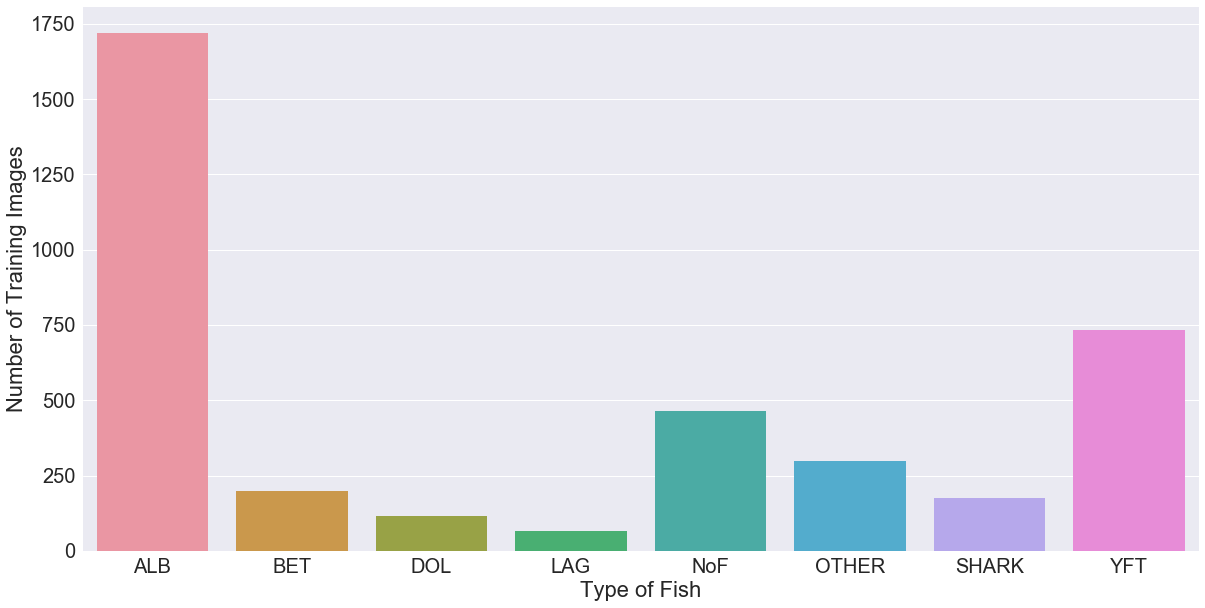

In [48]:
# create bar chart showing number of images of each type

sns.set_style('darkgrid')
plt.figure(figsize=(20,10))
sns.set(font_scale=2)
total_images = []
for fish in fish_labels:
    fish_species = get_images(fish)
    total_images.append(len(fish_species))

ax = sns.barplot(fish_labels, total_images)
ax.set(xlabel='Type of Fish', ylabel='Number of Training Images')

In [21]:
# Training Data loading
train_files = sorted(glob.glob('/Users/jamesdarmody/Documents/W207/Final/train/*/*.jpg'), key=lambda x: np.random.random())
train = np.array([imread(img) for img in train_files])
print('Length of train {}'.format(len(train)))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Length of train 3777


In [58]:
# finding the sizes of the images in pixels

print('Sizes in train:')
shapes = np.array([str(img.shape) for img in train])
pd.Series(shapes).value_counts()

Sizes in train:


(720, 1280, 3)    2174
(750, 1280, 3)     598
(974, 1280, 3)     395
(718, 1276, 3)     220
(670, 1192, 3)     198
(924, 1280, 3)      60
(854, 1518, 3)      39
(974, 1732, 3)      35
(750, 1334, 3)      31
(700, 1244, 3)      27
dtype: int64

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

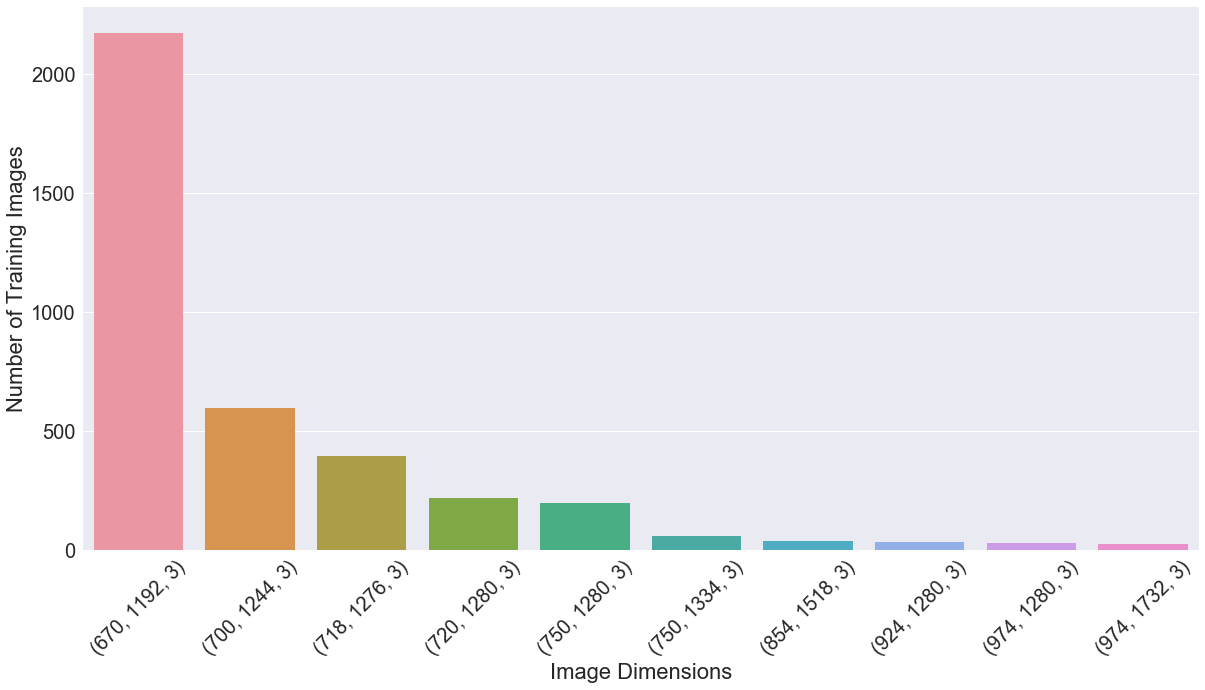

In [62]:
# create bar chart showing number of images of each type

sns.set_style('darkgrid')
plt.figure(figsize=(20,10))
sns.set(font_scale=2)

ax = sns.barplot(np.unique(shapes), pd.Series(shapes).value_counts())
ax.set(xlabel='Image Dimensions', ylabel='Number of Training Images')
plt.xticks(rotation=45)

In [69]:
def get_test_images():
    # Looks for sub-folder directory path given with function argument
    fish_dir = test_directory
    # Builds a list with names of all files labeled with function argument
    images = [im for im in os.listdir(fish_dir)]
    print("Test Images: {}".format(len(images)))
    
get_test_images()

Test Images: 1000


In [75]:
# Data loading Test
test_files = sorted(glob.glob('/Users/jamesdarmody/Documents/W207/Final/test_stg1/*.jpg'), key=lambda x: np.random.random())
test = np.array([imread(img) for img in test_files])
print('Length of test {}'.format(len(test)))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Length of test 1000


In [76]:
# finding the sizes of the images in pixels

print('Sizes in test:')
shapes_test = np.array([str(img.shape) for img in test])
pd.Series(shapes_test).value_counts()

Sizes in test:


(720, 1280, 3)    606
(750, 1280, 3)    148
(974, 1280, 3)     98
(718, 1276, 3)     57
(670, 1192, 3)     45
(854, 1518, 3)     21
(750, 1334, 3)     11
(924, 1280, 3)      7
(700, 1244, 3)      4
(974, 1732, 3)      3
dtype: int64

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

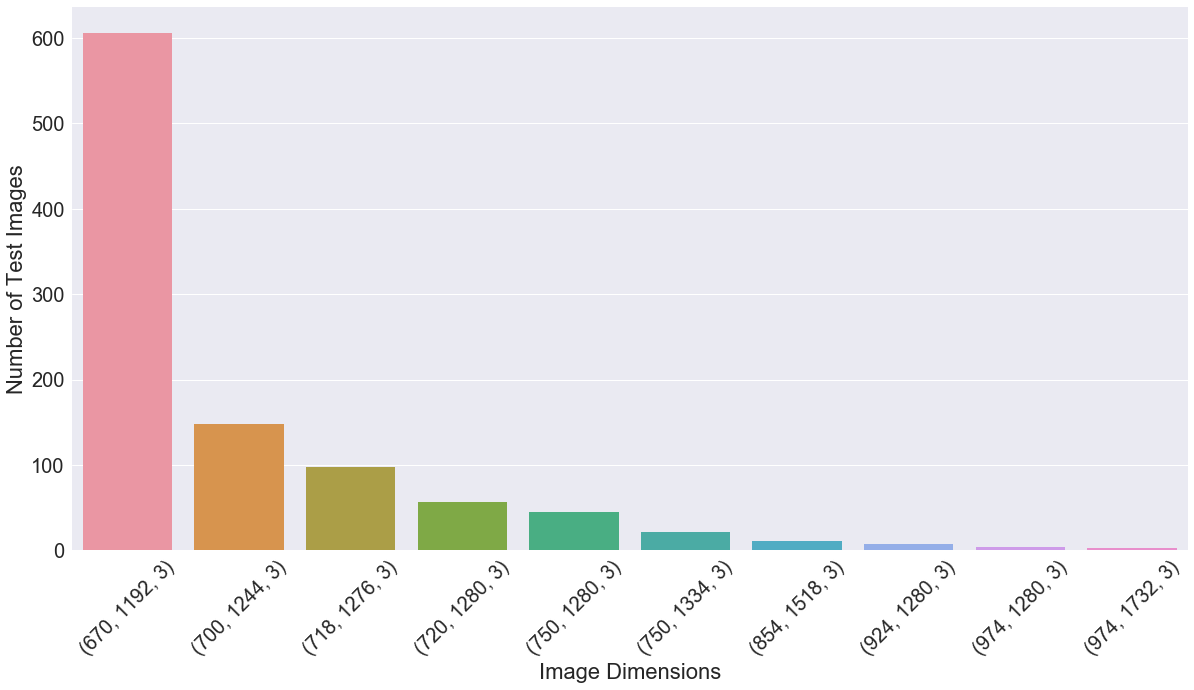

In [77]:
# create bar chart showing number of images of each type

sns.set_style('darkgrid')
plt.figure(figsize=(20,10))
sns.set(font_scale=2)

ax = sns.barplot(np.unique(shapes_test), pd.Series(shapes_test).value_counts())
ax.set(xlabel='Image Dimensions', ylabel='Number of Test Images')
plt.xticks(rotation=45)

In [93]:
# define function for reading image files with computer vision package
# specify number of columns and rows 
# larger number better score, but slower speed
# A channel is the grayscale image of same size as a color image made of one primary color
# color images have three channels (red, green, and blue)

column_pixels=160
row_pixels=90
channels=3

def read_image(src, columns, rows):
    image = cv2.imread(src, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (columns, rows), interpolation=cv2.INTER_LANCZOS4)
    return(image)

total_train_files = []
total_y = []


# to get lists of all training files and all labels associated
for fish in fish_labels:
    total_files = get_images(fish)
    total_train_files.extend(total_files)
    
    y_fish = np.tile(fish, len(total_files))
    total_y.extend(y_fish)
    
y_array = np.array(total_y)

# to get
total_X = np.ndarray((len(total_train_files), row_pixels, column_pixels, channels), dtype=np.uint8)

for i, image in enumerate(total_train_files):
    total_X[i] = read_image(train_directory+image, column_pixels, row_pixels)

In [110]:
# checking shape of array with labels
# one-hot categorical encoding of labels
# returns a binary class matrix
print(y_array.shape)
train_y_one_hot = LabelEncoder().fit_transform(y_array)
train_y_one_hot = np_utils.to_categorical(train_y_one_hot)

(3777,)


In [100]:
# checking shape of array of training data
total_X.shape

(3777, 90, 160, 3)

In [111]:
# splitting data
X_train, X_test, y_train, y_test = train_test_split(total_X, 
train_y_one_hot, random_state=0, stratify=train_y_one_hot)

In [154]:
# converting data from int8 to float32 for model
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [192]:
# reshaping training to 2d from 4d for scikit learn model
X2d = np.reshape(total_X, (3777, 43200))

In [194]:
X2d_train, X2d_test, y2d_train, y2d_test = train_test_split(
X2d, train_y_one_hot, random_state=0, stratify=train_y_one_hot)

In [195]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(solver='lbfgs', random_state=0,
    hidden_layer_sizes=(10,10), activation='tanh').fit(
    X2d_train, y_train)

In [197]:
print("Training Accuracy: {}".format(mlp.score(X2d_train, y_train)))
print("Training Accuracy: {}".format(mlp.score(X2d_test, y_test)))

Training Accuracy: 0.00035310734463276836
Training Accuracy: 0.0


In [170]:
# build the model
fish_model = Sequential()
fish_model.add(Conv2D(32,kernel_size=(3,3), activation='relu'))
fish_model.add(MaxPooling2D(pool_size=(2,2)))

fish_model.add(Conv2D(64,(3,3), activation='relu'))
fish_model.add(MaxPooling2D(pool_size=(2,2)))

fish_model.add(Conv2D(128,(3,3), activation='relu'))
fish_model.add(MaxPooling2D(pool_size=(2,2)))

fish_model.add(Flatten())
fish_model.add(Dense(128, activation='linear'))
fish_model.add(Dense(8, activation='softmax'))

In [188]:
fish_model.compile(loss=keras.losses.categorical_crossentropy, optimizer='sgd'
    ,metrics=['accuracy'])

AttributeError: module 'tensorflow' has no attribute 'log'